In [57]:
import networkx as nx
import pandas as pd
import numpy as np
import gurobipy as gp
from gurobipy import GRB
import random
import pickle
import osmnx as ox
import copy
import json
import os
import glob

In [58]:
"""
Input
"""
seed = 10
example = 8
num_nodes = 100
num_clients = 10
budget = 2
num_auto = 3
num_non_auto = 3
num_layer = 2

# Write the input to a file
input = ['seed', 'example', 'num_nodes', 'num_clients', 'budget', 'num_auto', 'num_non_auto']
input_dict = dict(zip(input, [seed, example, num_nodes, num_clients, budget, num_auto, num_non_auto]))
path = 'exact-model-'+str(example)
if not os.path.exists(path):
    os.mkdir('exact-model-' + str(example))
with open('exact-model-' +str(example) + '/input.json', 'w') as outfile:
    json.dump(input_dict, outfile)



In [59]:
"""
Set the seed
"""
random.seed(seed)
np.random.seed(seed)

In [60]:
"""
Build a graph
"""

# Read the network data 
G = pickle.load(open("Manhattan_network.p", "rb"))


# Generate the set of nodes of a subgraph by BFS
def graph_generator(G, num_nodes):
    V = list(G.nodes)
    E = list(G.edges)
    s = random.sample(V, 1)[0]

    visited = [s]
    frontier = [s]
    while len(visited) < num_nodes and len(frontier) > 0:
        i = frontier.pop(0)
        for j in G.neighbors(i):
            if j not in visited:
                visited.append(j)
                frontier.append(j)
    
    return visited

tmp_V = graph_generator(G, num_nodes)
G = G.subgraph(tmp_V)


# Extract the strongly connected components
tmp_V = max(nx.strongly_connected_components(G), key = len)
G = G.subgraph(list(tmp_V))
V = list(G.nodes)
E = list(G.edges)

# label mapping
old_to_new = {}
new_to_old = {}
index = 0
for i in V:
    new_to_old[index] = i
    old_to_new[i] = index
    index += 1

In [61]:
"""
Set parameters (key control params, as input, are in the first chunk)
"""

## Depots
K = random.sample(V, 1)

## Trucks
num_truck = num_auto + num_non_auto ### The first half are auto trucks
truck = np.arange(num_truck)

truck_range = (np.random.random(len(truck))) * 50 * 1600
truck_capacity = 10

# Fixed cost to dispatch a truck
truck_cost = np.repeat(100, len(truck))


## Clients
D = random.sample(list(set(V) - set(K)), num_clients)

demand = np.random.lognormal(0.1, 1, size=len(D))
demand[demand >= truck_capacity] = truck_capacity


## Time discretization

# The length of time intervals (in minutes)
gran = 1
# The # of operational hours (in hours)
op = 3
# Time span (in seconds)
T = op * 3600

num_interval = int((60 / gran) * op)
Q = np.arange(num_interval)
a = np.arange(0, T, gran * 60)
b = a + gran * 60

## Extra cost for remote control
control_cost = np.repeat(10, num_auto)



/home/zh223/miniconda3/lib/python3.7/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/zh223/miniconda3/lib/python3.7/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


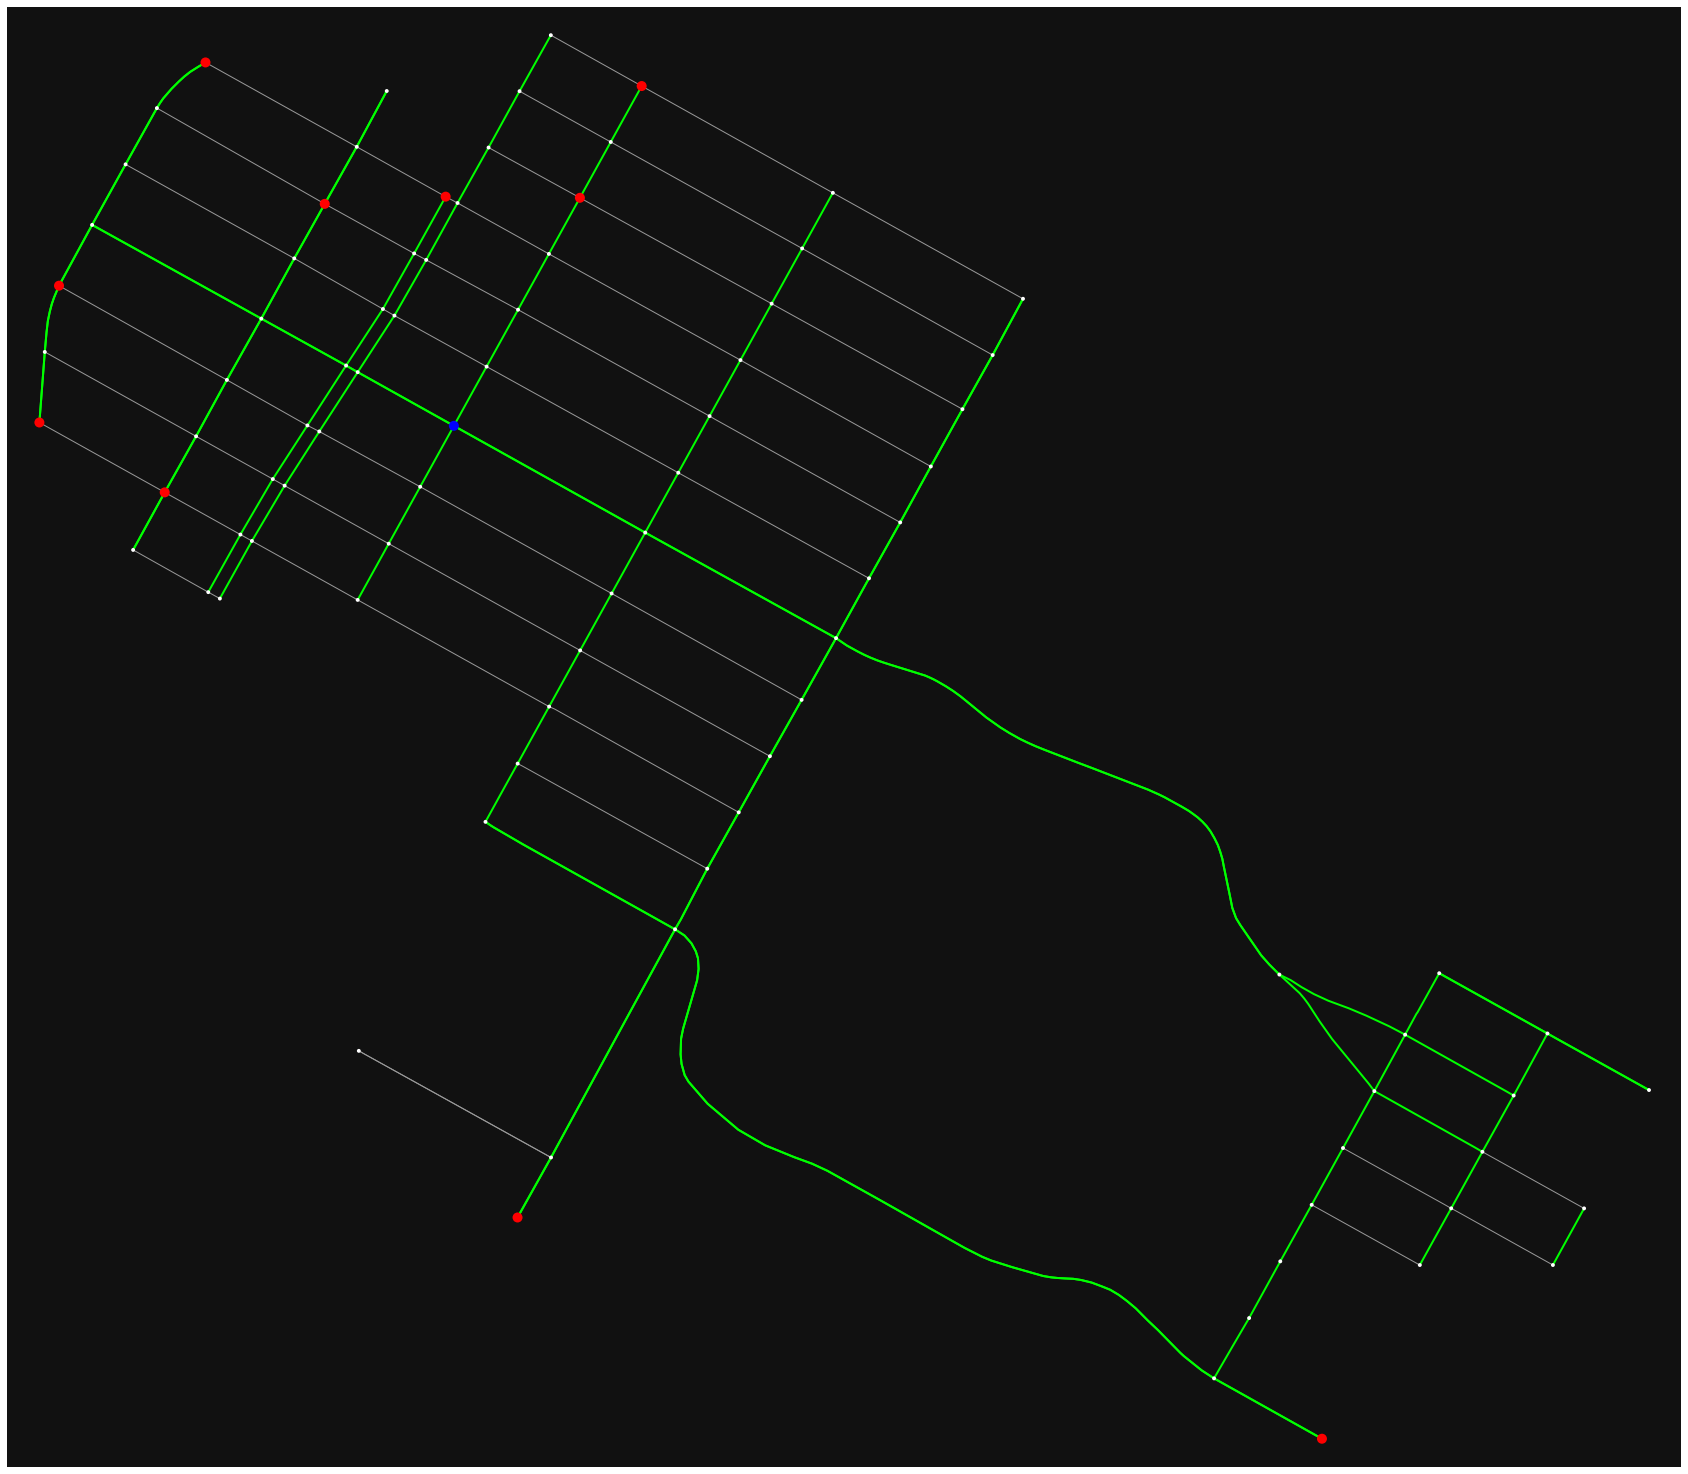

(<Figure size 2160x2160 with 1 Axes>, <AxesSubplot:>)

In [62]:
"""
Visualization
"""

# index_K = [i for i in range(len(V)) if V[i] in K]
# index_D = [i for i in range(len(V)) if V[i] in D]
index_auto_E = [i for i in range(len(E)) if G.edges[E[i]]['highway'] == 'primary' or G.edges[E[i]]['highway'] == 'secondary'] 
node_color = ['w' for _ in range(len(V))]
node_size = [15 for _ in range(len(V))]
edge_color = ['#999999' for _ in range(len(E))]
edge_linewidth = [1 for _ in range(len(E))]

for i in K:
    idx = old_to_new[i]
    node_color[idx] = 'b'
    node_size[idx] = 100
for i in D:
    idx = old_to_new[i]
    node_color[idx] = 'r'
    node_size[idx] = 100
for idx in index_auto_E:
    edge_color[idx] = '#00FF00'
    edge_linewidth[idx] = 2

ox.plot_graph(G, node_color = node_color, node_size = node_size, edge_color = edge_color, 
                edge_linewidth = edge_linewidth, figsize = (30, 30), save = True, filepath = 'exact-model-' + str(example) + '/network.png')

In [63]:
"""
Build the extended graph
"""

G_e = copy.deepcopy(G)
D_e = [old_to_new[i] for i in D]
for i in range(num_layer - 1):

    # Duplicate one more layer
    layer = copy.deepcopy(G) 
    G_e = nx.disjoint_union(G_e, layer)

    # Add artificial edges of customers 
    for j in D:
        idx_j = old_to_new[j]
        idx_1 = idx_j + i * len(V)
        idx_2 = idx_j + (i+1) * len(V)
        D_e.append(idx_2)
        G_e.add_edge(idx_1, idx_2, length = 0, highway = 'artificial', index = str(idx_1)+'-'+str(idx_2))

# Construct the demand dictionary
demand_dict = dict(zip(D_e, np.tile(demand, num_clients)))

# Construct the 2-D customer vertices
D_e_2d = np.reshape(D_e, (num_layer, len(D)))

# Add artificial edges of the depot
departure = old_to_new[K[0]]
K_e = []
for i in range(num_layer - 1):
    idx_1 = departure + i * len(V)
    idx_2 = departure + (num_layer - 1) * len(V)
    K_e.append(idx_1)
    G_e.add_edge(idx_1, idx_2, length = 0, highway = 'artificial', index = str(idx_1)+'-'+str(idx_2))
arrival = departure + (num_layer - 1) * len(V)
K_e.append(arrival)

# Make new lists of nodes and edges in the extended graph
E_e = list(G_e.edges())
V_e = list(G_e.nodes)


# Mapping for edges
edge_to_no = {}
no_to_edge = {}
index = 0
for e in E_e:
    no_to_edge[index] = e
    edge_to_no[e] = index
    index += 1

# Sanity Check 
counter = 0
for j in range(num_layer - 1):

    tmp_k = old_to_new[K[0]]
    print(G_e[tmp_k + j * len(V)][tmp_k + (num_layer-1) * len(V)])
    print('++++++++++++++++++++++')
    for i in D:
        tmp_i = old_to_new[i]
        print(G_e[tmp_i + j * len(V)][tmp_i + (j+1) * len(V)])
        counter += 1
    print('======================')

print("The size of the extended graph is: ")
print(len(E_e))
print(len(V_e))


{0: {'length': 0, 'highway': 'artificial', 'index': '54-144'}}
++++++++++++++++++++++
{0: {'length': 0, 'highway': 'artificial', 'index': '38-128'}}
{0: {'length': 0, 'highway': 'artificial', 'index': '47-137'}}
{0: {'length': 0, 'highway': 'artificial', 'index': '64-154'}}
{0: {'length': 0, 'highway': 'artificial', 'index': '19-109'}}
{0: {'length': 0, 'highway': 'artificial', 'index': '85-175'}}
{0: {'length': 0, 'highway': 'artificial', 'index': '39-129'}}
{0: {'length': 0, 'highway': 'artificial', 'index': '73-163'}}
{0: {'length': 0, 'highway': 'artificial', 'index': '58-148'}}
{0: {'length': 0, 'highway': 'artificial', 'index': '13-103'}}
{0: {'length': 0, 'highway': 'artificial', 'index': '67-157'}}
The size of the extended graph is: 
381
180


In [64]:
"""
Cost and travel time
"""


speed = 3.3528 # in meter/second
f1 = 0.8
f2 = 1


for e in E_e:
    e = (e[0], e[1], 0)
    G_e.edges[e]['travel_time'] = G_e.edges[e]['length'] / speed

for e in E_e:
    e = (e[0], e[1], 0)
    if G_e.edges[e]['highway'] == 'artificial':
        G_e.edges[e]['auto_cost'] = 0
        G_e.edges[e]['non_auto_cost'] = 0
    elif G_e.edges[e]['highway'] == 'primary' or G_e.edges[e]['highway'] == 'secondary':
        G_e.edges[e]['auto_cost'] = f1 * G_e.edges[e]['length']
        G_e.edges[e]['non_auto_cost'] = G_e.edges[e]['length']
    else:
        G_e.edges[e]['auto_cost'] = f2 * G_e.edges[e]['length']
        G_e.edges[e]['non_auto_cost'] = G_e.edges[e]['length']

In [65]:
# """
# The MILP solver (Dense Representation)
# """

# # Create a new model
# model = gp.Model('auto_truck')

# # Set the file path for logging
# model.Params.LogFile = 'example-' + str(example) + '/log.txt'


# # Create variables
# x = model.addMVar((len(V_e), len(V_e), num_truck), vtype=GRB.BINARY)
# y = model.addMVar((len(V_e), num_truck), vtype=GRB.BINARY)
# t = model.addMVar((len(V_e), num_truck), vtype=GRB.CONTINUOUS)
# u = model.addMVar((num_interval, num_auto), vtype=GRB.BINARY)
# alpha = model.addMVar((num_interval, len(V_e), len(V_e), num_auto), vtype=GRB.BINARY)
# beta = model.addMVar((num_interval, len(V_e), len(V_e), num_auto), vtype=GRB.BINARY)


# # Add constraints

# ## Flow conservation at all nodes (except the depot)
# model.addConstrs(sum(x[i, list(G_e.successors(i)), m]) == sum(x[list(G_e.predecessors(i)), i, m])
#                 for i in list(set(V_e) - set([departure, arrival]))
#                 for m in truck)

# ## Flow conservation at the depot
# model.addConstrs(sum(x[departure, list(G_e.successors(departure)), m]) == y[departure, m]
#                 for m in truck)
# model.addConstrs(sum(x[list(G_e.predecessors(arrival)), arrival, m]) == y[arrival, m]
#                 for m in truck)
# model.addConstrs(y[departure, m] == y[arrival, m]
#                 for m in truck)

# ## The # of truck used
# model.addConstr(sum(y[departure, :]) <= len(truck))

# ## Each truck serves only one customer
# model.addConstrs(sum(x[list(G_e.predecessors(i)), i, m]) >= y[i, m] for i in D_e for m in truck)
# model.addConstrs(sum(y[i, m] for i in D_e_2d[:, h] for m in truck) == 1 for h in range(len(D)))
    

# ## Transition
# for i in D_e + K_e[1 :]:
#     for j in D_e + K_e[1 :]:
#         if G_e.has_edge(i, j) and G_e[i][j][0]['highway'] == 'artificial':
#             model.addConstrs(x[i, j, m] == y[i, m] for m in truck)


# ## Range limit
# model.addConstrs(sum(G_e[i][j][0]['length'] * x[i, j, m] for i in V_e for j in V_e if G_e.has_edge(i, j)) <= truck_range[m]
#                 for m in truck)

# ## Capacity limit
# model.addConstrs(sum(demand_dict[i] * y[i, m] for i in D_e) <= 2 * truck_capacity
#                 for m in truck)

# ## Subtour elimination + time tracking
# for i in V_e:
#     for j in V_e:
#         if G_e.has_edge(i, j):
#             model.addConstrs(t[j, m] >= t[i, m] + G_e[i][j][0]['travel_time'] + T * (x[i, j, m] - 1) for m in truck)
# model.addConstrs(t[arrival, m] == t[departure, m] + sum(G_e[i][j][0]['travel_time'] * x[i, j, m] for i in V_e for j in V_e if G_e.has_edge(i, j))
#                 for m in truck)

# ## Budget of remote control
# model.addConstrs(sum(u[q, :]) <= budget for q in Q)

# ## Time consistency of a truck being remotely controlled
# for i in V_e:
#     for j in V_e:
#         if G_e.has_edge(i, j) and G_e[i][j][0]['highway'] == 'primary':
#             model.addConstrs(3 * u[q, m] >= alpha[q, i, j, m] + beta[q, i, j, m] + x[i, j, m] - 2
#                             for q in Q
#                             for m in truck[: num_auto])
#             model.addConstrs(t[j, m] - T * (alpha[q, i, j, m]) <= a[q]
#                             for q in Q
#                             for m in truck[: num_auto])
#             model.addConstrs(t[i, m] >= b[q] - T * (beta[q, i, j, m])
#                             for q in Q
#                             for m in truck[: num_auto])


# # Add the objective
# model.setObjective(sum(x[i, j, m] * G_e[i][j][0]['auto_cost'] for i in V_e for j in V_e for m in truck[: num_auto] if G_e.has_edge(i, j)) + 
#                    sum(x[i, j, m] * G_e[i][j][0]['non_auto_cost'] for i in V_e for j in V_e for m in truck[num_auto :] if G_e.has_edge(i, j)),
#                    GRB.MINIMIZE)

# # Wirte the model itself
# # model.write('example-' + str(example) +'/model.lp')

# # Solve the VRP
# model.optimize()

# # Write the solution
# # model.write('example-' + str(example) + '/solution.sol')

In [66]:
"""
The MILP Sovler (Sparse Representation)
"""

# Create a new model
model = gp.Model('exact_model')

# Set the file path for logging
path = 'exact-model-' + str(example) + '/exact_model_log.txt'
if os.path.exists(path):
    os.remove(path)
model.Params.LogFile = path

# Parameters tuning for the MIP solver
model.Params.MIPFocus = 3 # Focusing on the phase 2 (getting good quality solutions)
# model.Params.MIPGap = 0.05 # Specify the terminating duality gap

# Create variables
x = model.addMVar((len(E_e), num_truck), vtype=GRB.BINARY)
y = model.addMVar((len(V_e), num_truck), vtype=GRB.BINARY)
t = model.addMVar((len(V_e), num_truck), vtype=GRB.CONTINUOUS)
u = model.addMVar((num_interval, num_auto), vtype=GRB.BINARY)
alpha = model.addMVar((num_interval, len(E_e), num_auto), vtype=GRB.BINARY)
beta = model.addMVar((num_interval, len(E_e), num_auto), vtype=GRB.BINARY)


# Add constraints

## Flow conservation at all nodes (except the depot)
for i in list(set(V_e) - set([departure, arrival])):
    out_no = [edge_to_no[e] for e in list(G_e.out_edges(i))]
    in_no = [edge_to_no[e] for e in list(G_e.in_edges(i))]
    model.addConstrs(sum(x[out_no, m]) == sum(x[in_no, m]) for m in truck)
    model.addConstrs(sum(x[out_no, m]) <= 1 for m in truck)

## Flow conservation at the depot
departure_out = [edge_to_no[e] for e in list(G_e.out_edges(departure))]
arrival_in = [edge_to_no[e] for e in list(G_e.in_edges(arrival))]

model.addConstrs(sum(x[departure_out, m]) == y[departure, m]
                for m in truck)
model.addConstrs(sum(x[arrival_in, m]) == y[arrival, m]
                for m in truck)
model.addConstrs(y[departure, m] == y[arrival, m]
                for m in truck)

## The # of truck used
model.addConstr(sum(y[departure, :]) <= num_truck)


## Allow a vehicle to pass thru a customer without serving it 
for i in D_e:
    i_in = [edge_to_no[e] for e in list(G_e.in_edges(i))]
    model.addConstrs(sum(x[i_in, m]) >= y[i, m] for m in truck)

## Each truck serves only one customer
model.addConstrs(sum(y[i, m] for i in D_e_2d[:, h] for m in truck) == 1 for h in range(len(D)))


## Transition
for i in D_e:
    for j in D_e:
        if G_e.has_edge(i, j) and G_e[i][j][0]['highway'] == 'artificial':
            model.addConstrs(x[edge_to_no[(i, j)], m] == y[i, m] for m in truck)

## Range limit
model.addConstrs(sum(G_e[i][j][0]['length'] * x[edge_to_no[(i, j)], m] for i in V_e for j in V_e if G_e.has_edge(i, j)) <= truck_range[m]
                for m in truck)

## Capacity limit
model.addConstrs(sum(demand_dict[i] * y[i, m] for i in D_e) <= truck_capacity
                for m in truck)
            
# Subtour elimination + time tracking
for i in V_e:
    for j in V_e:
        if G_e.has_edge(i, j):
            model.addConstrs(t[j, m] >= t[i, m] + G_e[i][j][0]['travel_time'] + T * (x[edge_to_no[(i, j)], m] - 1) for m in truck)
model.addConstrs(t[arrival, m] == t[departure, m] + sum(G_e[i][j][0]['travel_time'] * x[edge_to_no[(i, j)], m] for i in V_e for j in V_e if G_e.has_edge(i, j))
                for m in truck)
model.addConstrs(t[departure, m] == 0 for m in truck)

## Budget of remote control
model.addConstrs(sum(u[q, :]) <= budget for q in Q)

## Time consistency of a truck being remotely controlled
for i in V_e:
    for j in V_e:
        if G_e.has_edge(i, j) and (G_e[i][j][0]['highway'] != 'primary' and G_e[i][j][0]['highway'] != 'secondary'):
            model.addConstrs(3 * u[q, m] >= alpha[q, edge_to_no[(i, j)], m] + beta[q, edge_to_no[(i, j)], m] + x[edge_to_no[(i, j)], m] - 2
                            for q in Q
                            for m in truck[: num_auto])
            model.addConstrs(t[j, m] - T * (alpha[q, edge_to_no[(i, j)], m]) <= a[q]
                            for q in Q
                            for m in truck[: num_auto])
            model.addConstrs(t[i, m] >= b[q] - T * (beta[q, edge_to_no[(i, j)], m])
                            for q in Q
                            for m in truck[: num_auto])

# Add the objective
model.setObjective(sum(x[edge_to_no[(i, j)], m] * G_e[i][j][0]['auto_cost'] for i in V_e for j in V_e for m in truck[: num_auto] if G_e.has_edge(i, j)) + 
                   sum(x[edge_to_no[(i, j)], m] * G_e[i][j][0]['non_auto_cost'] for i in V_e for j in V_e for m in truck[num_auto :] if G_e.has_edge(i, j)) +
                   y[departure, :] @ truck_cost + 
                   sum(u[q, :] @ control_cost for q in Q),
                   #* The last term by itself accounts for the extra cost of remote control
                   #* The last term can also avoid unneccesary positive u_{qm}
                   #* Adding this term affect the computational efficiency
                   GRB.MINIMIZE)

# Solve the VRP
model.optimize()

Set parameter LogFile to value "exact-model-8/exact_model_log.txt"
Set parameter MIPFocus to value 3
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (linux64)
Thread count: 16 physical cores, 32 logical processors, using up to 32 threads
Optimize a model with 197615 rows, 416466 columns and 533526 nonzeros
Model fingerprint: 0xb120dc76
Variable types: 1080 continuous, 415386 integer (415386 binary)
Coefficient statistics:
  Matrix range     [4e-01, 1e+04]
  Objective range  [1e+01, 1e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 6e+04]
Presolve removed 2426 rows and 285441 columns (presolve time = 6s) ...
Presolve removed 12791 rows and 292356 columns (presolve time = 10s) ...
Presolve removed 12791 rows and 292356 columns
Presolve time: 10.01s
Presolved: 184824 rows, 124110 columns, 497098 nonzeros
Variable types: 1008 continuous, 123102 integer (123102 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Root relaxation

In [ ]:
# """
# Extract the routes (Dense Representation)
# """

# route = []
# tmp_route = [departure]

# for m in truck:
    
#     departure_succ = list(G_e.successors(departure))
#     departure_outflow = x[departure, departure_succ, m].X
#     if sum(departure_outflow) == 0:
#         route.append([])
#         continue
    
#     route_m = [new_to_old[departure]]
#     i = departure
#     while i != arrival:
#         succ = list(G_e.successors(i))
#         outflow = x[i, succ, m].X
#         next = int(succ @ outflow)
#         if next % len(V) != i % len(V):
#             route_m.append(new_to_old[next % len(V)])
#         i = next
#         if m == 1:
#             tmp_route.append(i)
#     route.append(route_m)



In [67]:
"""
Extract the routes (Sparse Representation)
"""

route = []
# tmp_route = [departure]

for m in truck:
    
    departure_out_edge_no = [edge_to_no[e] for e in list(G_e.out_edges(departure))]
    departure_outflow = x[departure_out_edge_no, m].X
    
    if sum(departure_outflow) == 0:
        route.append([])
        continue
    
    route_m = [new_to_old[departure]]
    i = departure
    while i != arrival:

        i_out_edges = list(G_e.out_edges(i))
        i_out_edges_no = [edge_to_no[e] for e in i_out_edges]
        i_outflow = x[i_out_edges_no, m].X
        next_edge = i_out_edges[np.where(i_outflow)[0][0]]
        next_node = next_edge[1]
        
        if next_node % len(V) != i % len(V):
            route_m.append(new_to_old[next_node % len(V)])
        i = next_node
        # if m == 1:
            # tmp_route.append(i)
    route.append(route_m)

In [68]:
"""
Write the routes to a json file
"""

dict_routes = dict(zip(range(len(route)), route))
with open('exact-model-' +str(example) + '/routes.json', 'w') as outfile:
    json.dump(dict_routes, outfile)

/home/zh223/miniconda3/lib/python3.7/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/zh223/miniconda3/lib/python3.7/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


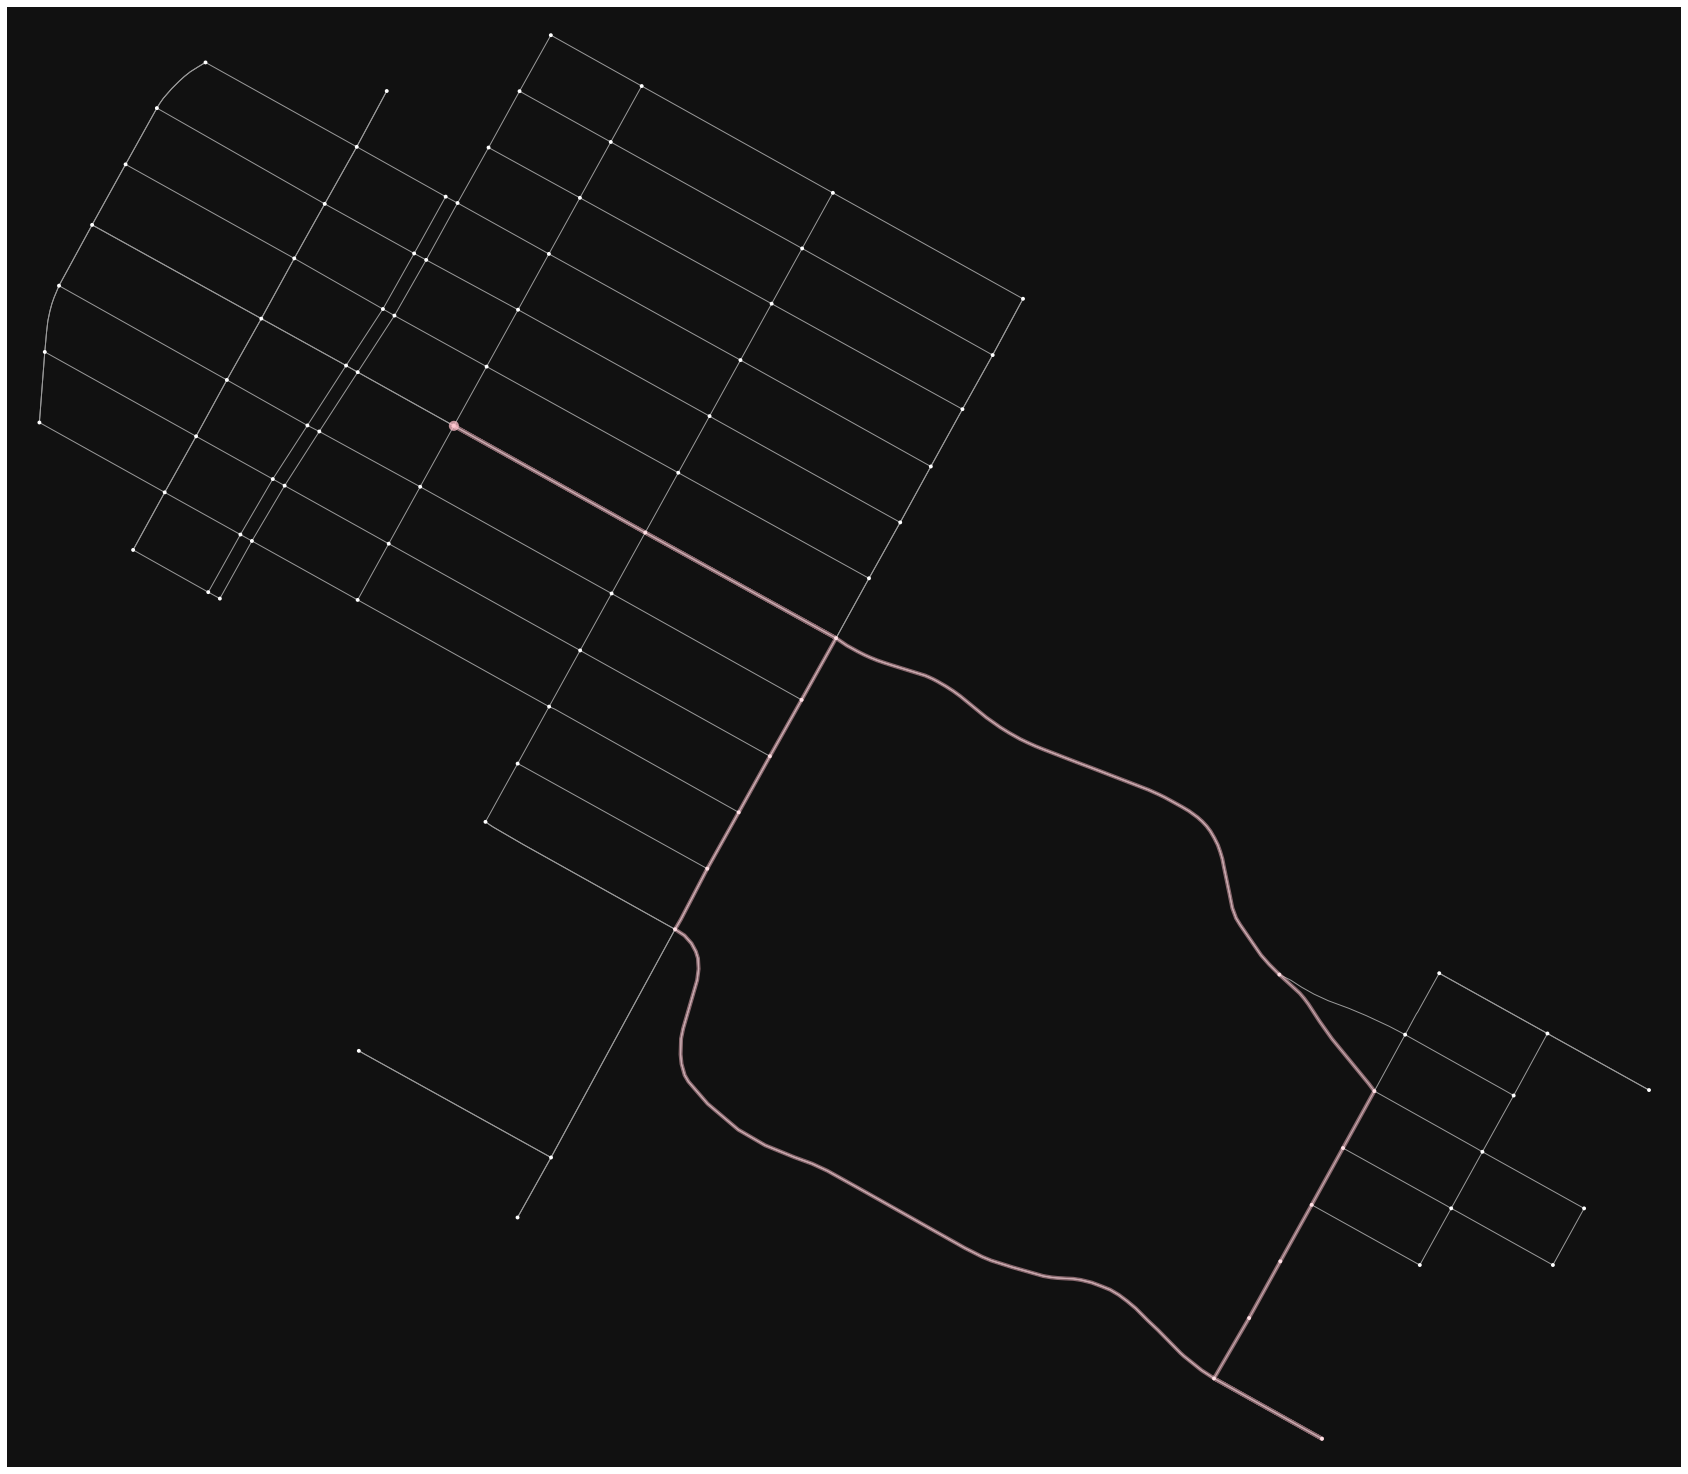

/home/zh223/miniconda3/lib/python3.7/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/zh223/miniconda3/lib/python3.7/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


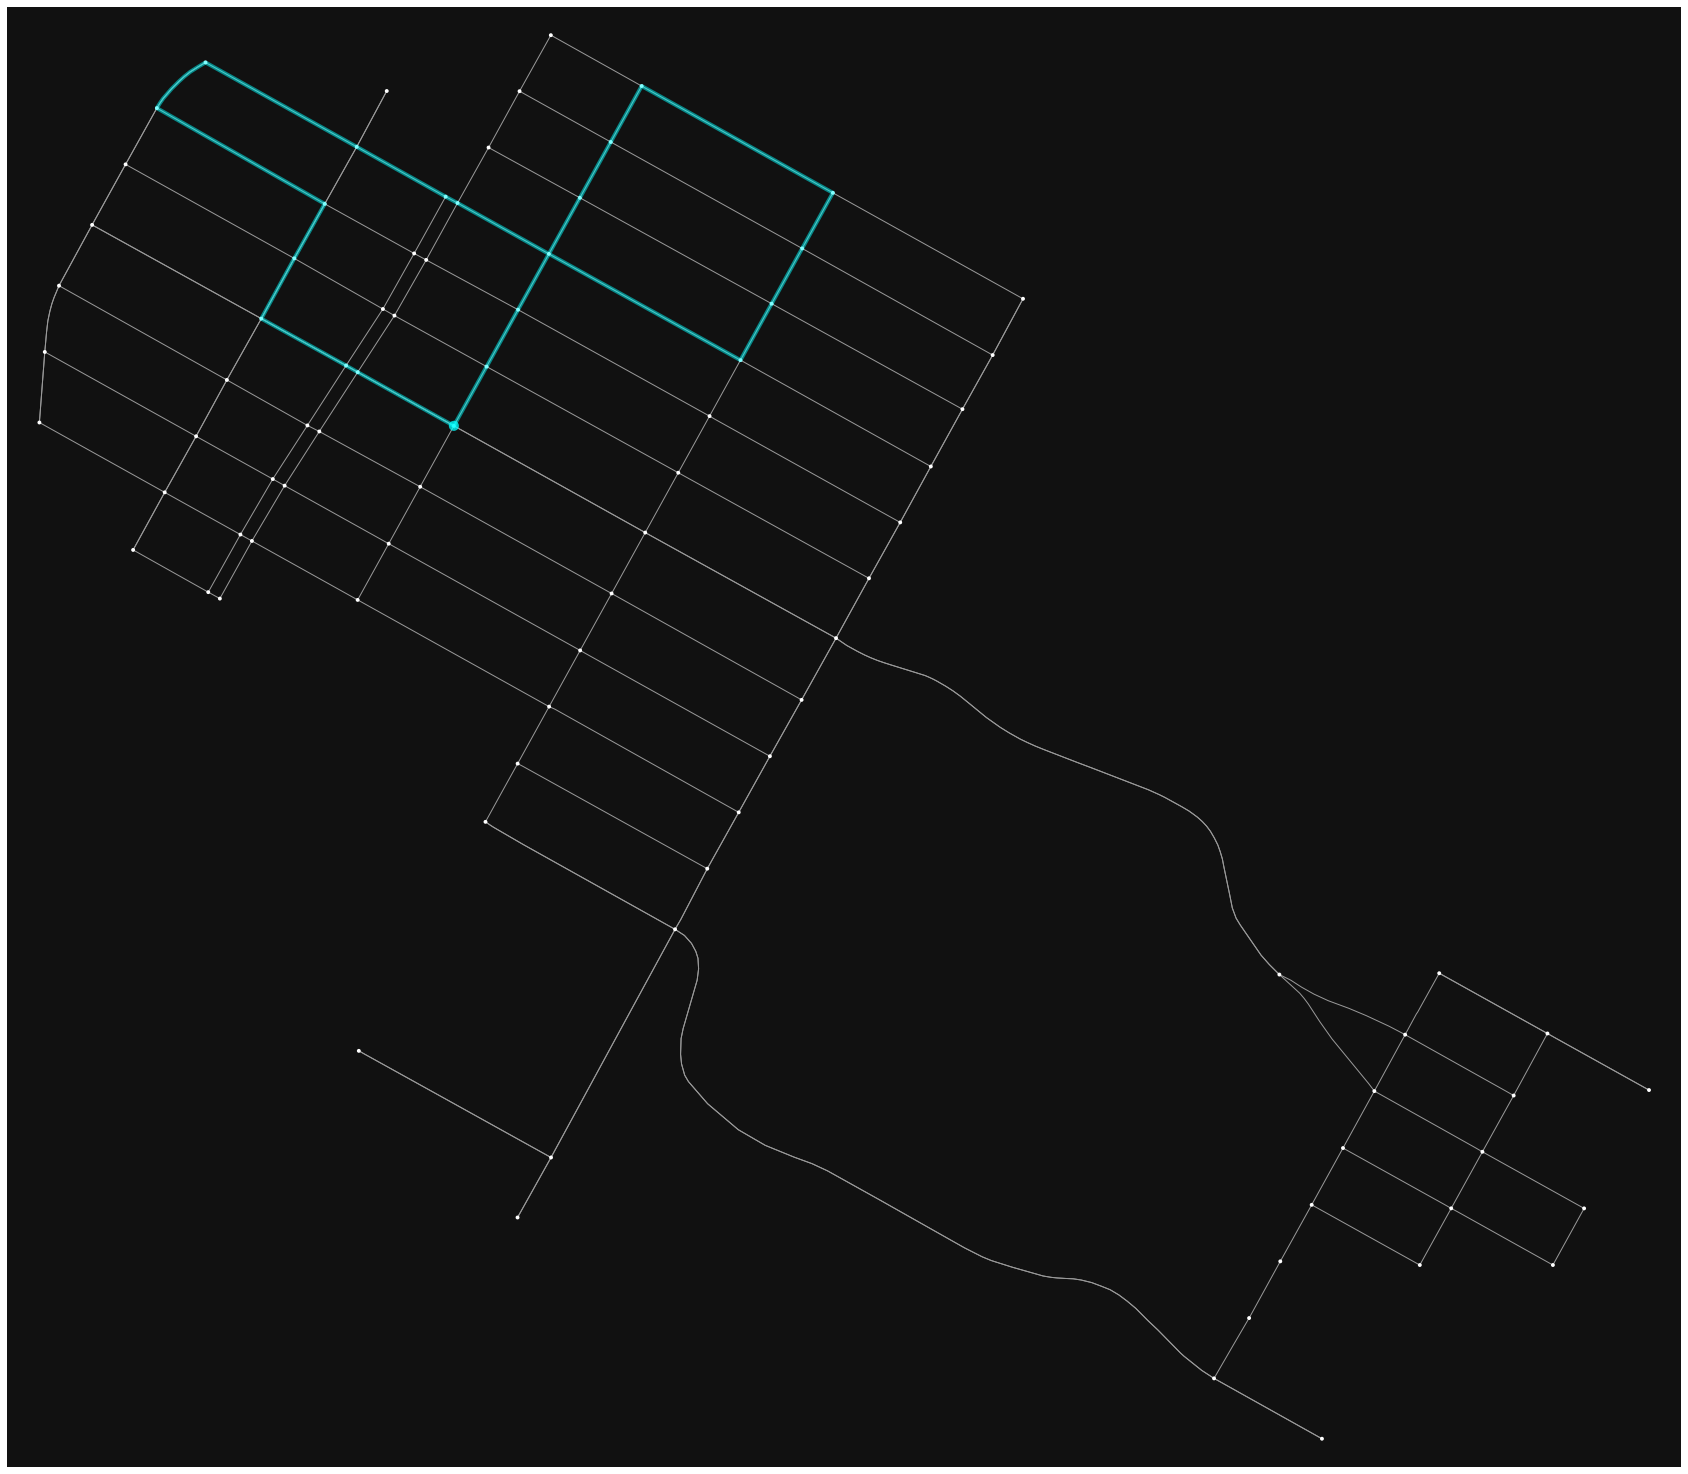

/home/zh223/miniconda3/lib/python3.7/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/zh223/miniconda3/lib/python3.7/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


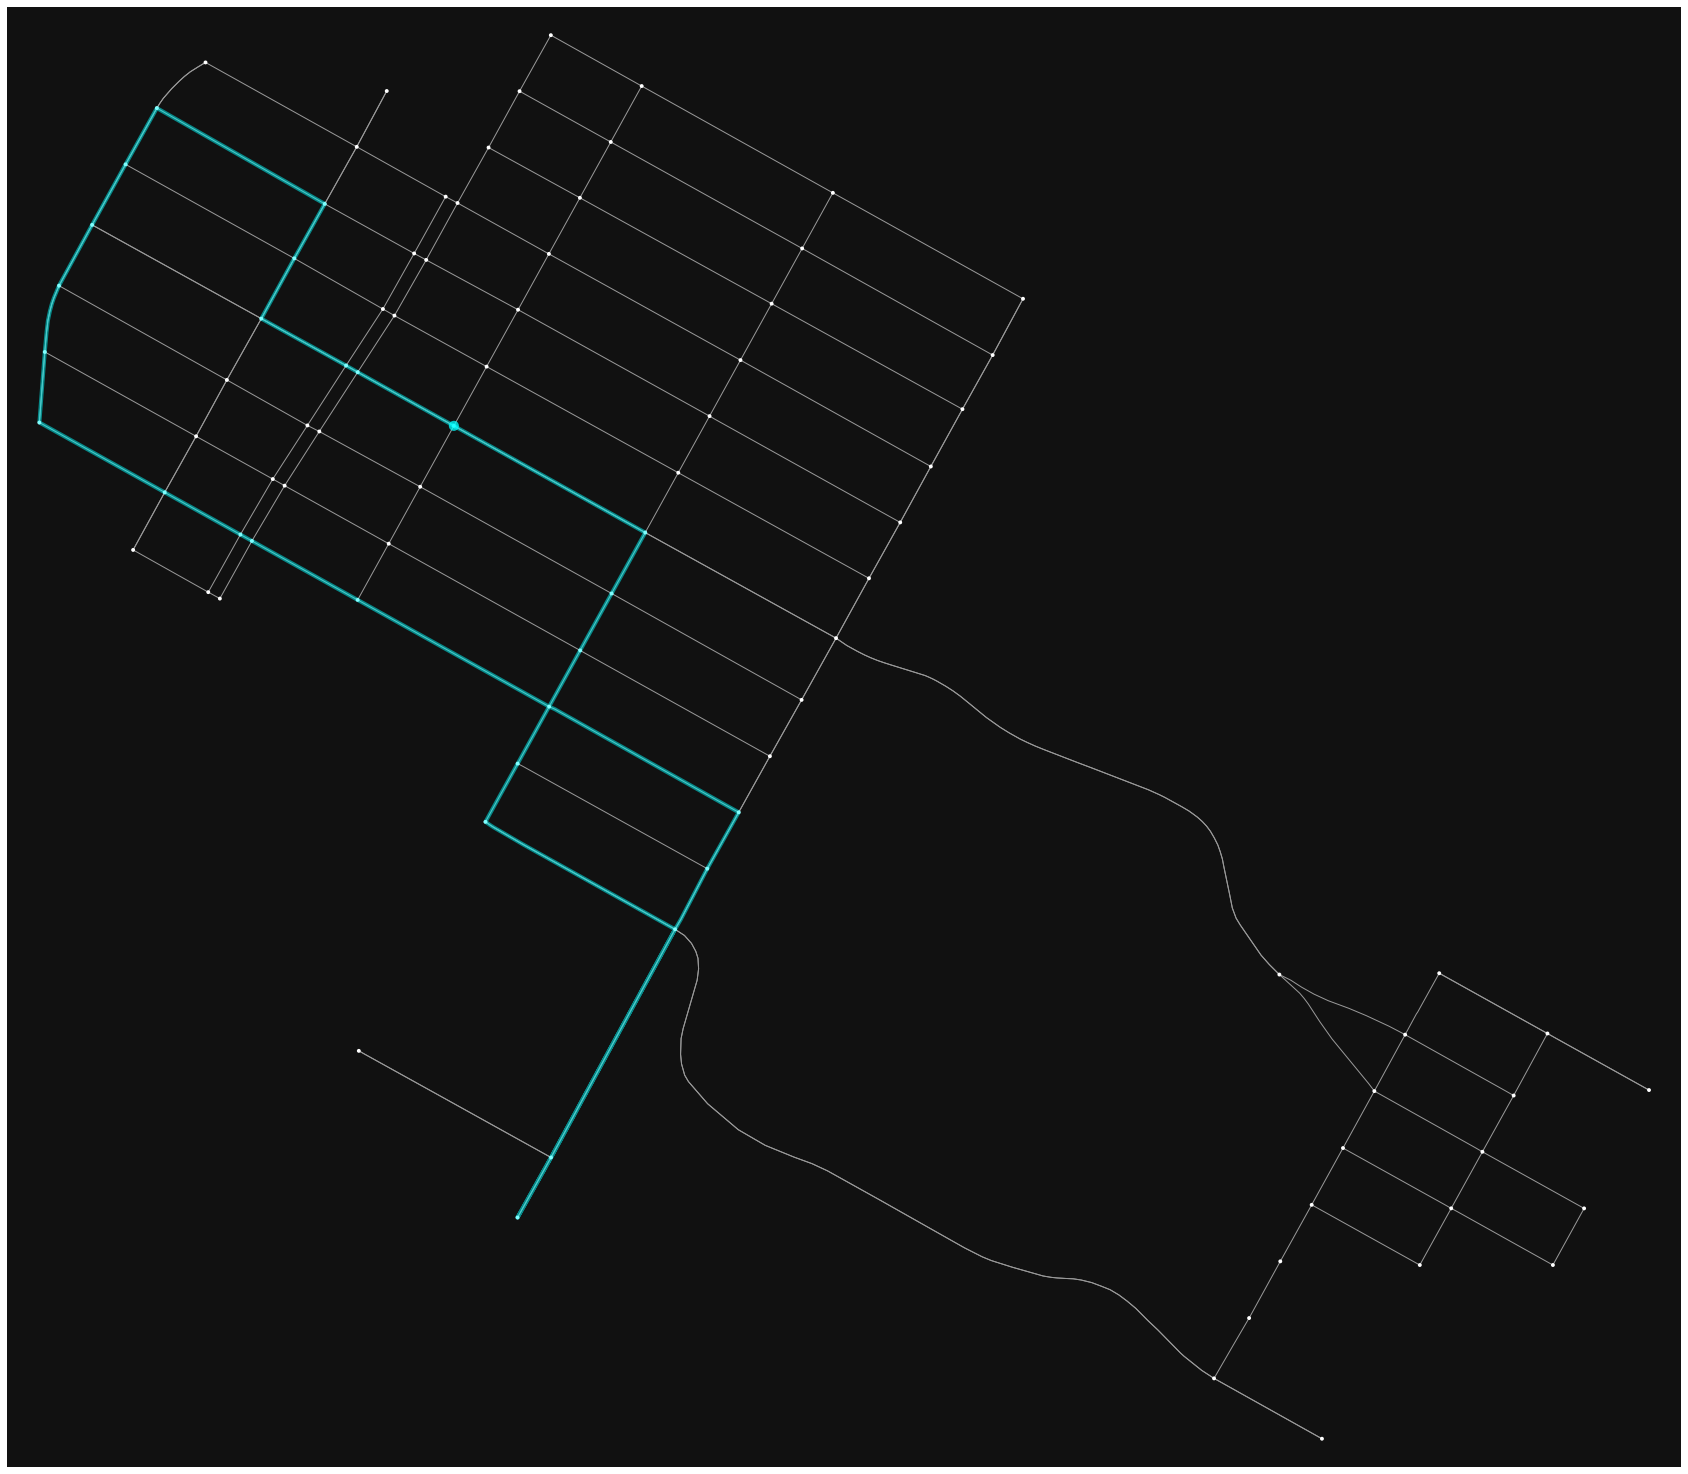

In [69]:
"""
Visualize all routes and output the figures 
"""


# color_list = []
# for i in range(5):
#     random_number = random.randint(0,16777215)
#     hex_number = str(hex(random_number))
#     hex_number ='#'+ hex_number[2:]
#     color_list.append(hex_number)
# print(color_list)

# Remove old figures
for figure in glob.glob("exact-model-"+str(example)+'/route-*'):
    os.remove(figure)


counter = 0
for m in range(len(route)):
    if len(route[m]) <= 1:
        counter += 1
    if len(route[m]) > 1:
        if m < num_auto:
            color = '#FFC0CB'
        else:
            color = '#00FFFF'
        ox.plot.plot_graph_route(G, route[m], route_color = color, route_linewidth=4,
                        route_alpha=0.5, orig_dest_size=100, figsize = (30, 30), save = True, filepath = 'exact-model-' + str(example) + '/route-' + str(m - counter + 1)+'.png')

In [70]:
num_control = {'control_vector': list(np.sum(u.X, axis=1))}
with open('exact-model-' +str(example) + '/control.json', 'w') as outfile:
    json.dump(num_control, outfile)

In [ ]:
# Sanity check for the solution numerically 

# m = 2
# print('t_im: ' + str(t[0, m].X))
# print('t_jm: ' + str(t[1, m].X))
# print('delta_t: ' + str(t[1, m].X - t[0, m].X))
# print('travel_time: ' + str(G_e[0][1][0]['travel_time']))
# print('a_q: ' + str(a[0]))
# print('b_q: ' + str(b[0]))
# print('alpha: ' + str(alpha[0, 0, 1, 0].X))
# print('beta: ' + str(beta[0, 0, 1, 0].X))


In [ ]:
# More debugging test

# print(tmp_route)
# print(route)
# print(new_to_old[53])
# print(new_to_old[15])
# print(G_e.has_edge(53, 15))
# print(G.has_edge(42432871, 42455963))
# print(list(G.successors(K[0])))
# print(list(G_e.successors(53)))
# print(old_to_new[42454660])

In [ ]:
# Check that disjoint_union works

# W = nx.Graph([(0, 1), (323, 333)])
# print(W.nodes())
# R = copy.deepcopy(W)
# print(R.nodes())
# I = nx.disjoint_union(W, R)
# print(I.nodes())
# print(I.has_edge(6, 5))